<a href="https://www.kaggle.com/code/minhthonglai/ielts-gptj-tuner?scriptVersionId=242608378" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# GPT-J Fine-tuning for Essay Scoring

## Global Setting Variables

In [47]:
MODEL_PATH = 'models/'
DATA_PATH = 'data/'
RANDOM_SEED = 42 # Set to `None` for the generator uses the current system time.

## System configurations 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when create a version using "Save & Run All" 
# Can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import sys
import os

# Check Python version
print(f"Python Version: `{sys.version}`")  # Detailed version info
print(f"Base Python location: `{sys.base_prefix}`")
print(f"Current Environment location: `{os.path.basename(sys.prefix)}`", end='\n\n')

Python Version: `3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]`
Base Python location: `/usr`
Current Environment location: `usr`



In [2]:
import torch
import time  # for CPU timing

# Check if GPU is available and being used
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")
    print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9} GB")

# This code will work in both CPU and GPU environments
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    
# Test with a simple operation - modified to work on both CPU and GPU
x = torch.rand(10000, 10000, device=device)
y = torch.rand(10000, 10000, device=device)

if device.type == "cuda":
    # GPU timing approach
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    z = x @ y  # Matrix multiplication
    end.record()
    torch.cuda.synchronize()
    print(f"Operation time: {start.elapsed_time(end)} ms")
else:
    # CPU timing approach
    start_time = time.time()
    z = x @ y  # Matrix multiplication
    end_time = time.time()
    print(f"Operation time: {(end_time - start_time) * 1000} ms")

CUDA available: False
Using device: cpu
Operation time: 14637.798309326172 ms


## Install required libraries

In [3]:
# %pip install transformers peft datasets accelerate bitsandbytes trl
# %pip install sentencepiece

## Import Libraries and Set Configuration

In [4]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from datasets import load_dataset

import os
import re
import matplotlib.pyplot as plt

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available. Setting up GPU environment...")
    # Set maximum GPU memory usage to avoid OOM errors
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    torch.cuda.empty_cache()
else:
    print("No GPU detected. Running in CPU-only mode.")
    # Ensure CUDA is disabled
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Enable memory efficient attention - works for both CPU and GPU
os.environ["TRANSFORMERS_OFFLINE"] = "1"  # Work offline if model is downloaded

2025-05-29 18:56:29.093182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748544989.343242      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748544989.414677      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


No GPU detected. Running in CPU-only mode.


## Prepare the IELTS Dataset

### Sample code to create a dataset for IELTS assessment


Need to prepare the dataset with this structure:

```
Data format structure:

data = {
  "input": [
    """Rate this IELTS essay:

Topic: [topic essay text]

Essay: [student essay text]""", ...
    ],

  "output": [
    """Task Achievement: [band score] - [detailed feedback]

Coherence and Cohesion: [band score] - [detailed feedback]

Lexical Resource: [band score] - [detailed feedback]

Grammatical Range and Accuracy: [band score] - [detailed feedback]

Overall Band Score: [band score]""", ...
    ]
}
```

In [25]:
from datasets import Dataset

# Comprehensive example data for IELTS assessment across different levels
data = {
    "input": [
        # Low Band Example (5.0-5.5)
        """Rate this IELTS essay: 

Topic: Some people think that governments should spend money on building train and subway lines to reduce traffic congestion. Others think that building more and wider roads is the better way to reduce traffic congestion. Discuss both views and give your opinion.

Essay:
Today traffic is big problem in many city in the world. Some people say government need to build train and subway to fix this problem. Other people think making more road is better solution. I will discuss both idea and give my opinion.

First, making train and subway is good idea because many people can travel together. If 100 people go in one train, it means maybe 50 cars are not in road. Also train and subway don't need parking place in city center. Many cars need parking and this take a lot of space in city. Train also more cheap for people who travel every day to work.

Second idea is making more roads and wider roads for cars. This is also good because many people like to drive own car. It is comfortable and private. You can go anywhere you want with car but train only go to some station. Also with car you can carry many things like shopping or luggage.

In my opinion, I think train and subway is better solution for big city. Because many cars make pollution and noise. Also train is faster in busy time because no traffic jam for train. But car is still necessary for some people. So government should make good public transport and also some road, but not too many road.

In conclusion, I believe that government should spend more money for train and subway, but also make some road for car. But train is better solution for traffic problem and environment.
""",

        # Mid Band Example (6.5)
        """Rate this IELTS essay: 

Topic: Some people believe that unpaid community service should be a compulsory part of high school programs. To what extent do you agree or disagree?

Essay:
There is growing debate regarding whether community service should be mandatory for high school students. While some argue that such requirements promote civic responsibility and personal development, others contend that forced volunteerism contradicts the very nature of community service. In my opinion, I partially agree that community service should be incorporated into high school curricula, but with certain limitations.

Mandatory community service offers several advantages for student development. Primarily, it exposes young people to social issues they might otherwise remain unaware of, fostering empathy and social consciousness. For instance, students volunteering at homeless shelters or food banks gain firsthand understanding of poverty and inequality in their communities. Moreover, these experiences help develop soft skills such as teamwork, communication, and leadership that are valuable for future academic and professional pursuits. Research has demonstrated that students who participate in community service often show improved academic performance and higher rates of civic engagement later in life.

However, forcing students to volunteer presents significant drawbacks. The compulsory nature of such programs may generate resentment and undermine the intrinsic value of helping others. When students participate reluctantly, the quality of their service suffers, potentially creating negative experiences for both the students and the communities they serve. Additionally, some students already face considerable academic pressure and family responsibilities, and mandatory service requirements might impose undue burden on their limited time.

A balanced approach would involve integrating community service opportunities into the curriculum without strict hourly requirements. Schools could offer a variety of service options aligned with different courses, allowing students to choose activities that match their interests and schedules. This approach would preserve the educational benefits while respecting student autonomy and different life circumstances.

In conclusion, while I believe in the value of community service as part of education, I think schools should encourage rather than mandate participation. Providing structured opportunities and recognition for voluntary service would better foster genuine civic engagement than compulsory requirements.
""",

        # High Band Example (8.0-8.5)
        """Rate this IELTS essay: 

Topic: Some people believe that visitors to other countries should follow local customs and behavior. Others disagree and think that the host country should welcome cultural differences. Discuss both these views and give your own opinion.

Essay:
The question of whether international visitors should adapt to local customs or maintain their own cultural practices when abroad represents a nuanced cultural and ethical dilemma. While there are compelling arguments for both cultural adaptation and preservation of diversity, this essay will analyze both perspectives before presenting a balanced position.

Proponents of cultural adaptation emphasize that adopting local customs demonstrates respect for the host society. When visitors make concerted efforts to observe indigenous practices, from removing shoes before entering homes in Japan to maintaining appropriate attire in religious sites across the Middle East, they acknowledge the values underpinning these traditions. This respectful approach facilitates meaningful cross-cultural engagement and mitigates potential misunderstandings or offense. Furthermore, embracing local customs offers visitors authentic insights into different worldviews and social structures that might otherwise remain inaccessible, thereby enriching their international experience.

Conversely, advocates for cultural diversity contend that globalization's value lies precisely in the exchange of varied perspectives and practices. They argue that host countries benefit immensely from exposure to different cultural expressions, from cuisine and art to social customs and business practices. Many thriving metropolitan centers like London, New York, and Singapore attribute their dynamism and innovation to their multicultural character. From this viewpoint, expecting visitors to abandon their cultural identity represents a lost opportunity for mutual enrichment and contradicts principles of individual expression and authenticity.

In reconciling these positions, it becomes evident that context and degree are paramount considerations. Certain fundamental legal and ethical norms must be respected regardless of cultural background. However, beyond these essential boundaries, a thoughtful balance can be achieved. Visitors should make reasonable efforts to understand and respect core local values and practices, particularly in settings where certain behaviors may cause genuine offense or disruption. Simultaneously, host societies benefit from cultivating openness toward cultural differences in areas where diversity poses no significant social harm.

In conclusion, while visitors should demonstrate cultural sensitivity by observing fundamental local customs, particularly in more conservative or traditional settings, host countries equally benefit from embracing reasonable cultural differences. This balanced approach fosters authentic cross-cultural understanding while preserving the rich tapestry of global cultural heritage. The most meaningful international exchanges occur when mutual respect allows both adaptation and diversity to coexist.
"""
    ],
    
    "output": [
        # Low Band Score (5.5)
        """Task Achievement: 5.0 - The essay addresses both views but development of ideas is limited. entries are mostly general rather than specific and some parts of the task receive inadequate attention.

Coherence and Cohesion: 5.0 - The writing is organized with some use of paragraphing and basic linking words, but the overall progression of ideas lacks sophistication. There are some lapses in cohesion and the conclusion partially repeats rather than fully summarizing.

Lexical Resource: 5.0 - Uses a limited range of vocabulary with some attempt at more complex items but with noticeable errors. Word choice is sometimes inaccurate and repetitive. Spelling and word formation errors are evident but don't significantly impede communication.

Grammatical Range and Accuracy: 5.5 - Uses a mix of simple and complex sentence forms but with frequent grammatical errors. Article usage, subject-verb agreement, and plural forms contain systematic errors. Control of tense and sentence structure is inconsistent.

Overall Band Score: 5.0""",
        
        # Mid Band Score (6.5)
        """Task Achievement: 7.0 - The essay addresses all parts of the task. The writer's position is clear and consistent throughout. Ideas are extended and supported, though some supporting arguments could be more fully developed with specific examples.

Coherence and Cohesion: 6.5 - Information and ideas are generally arranged coherently with clear overall progression. Paragraphing is logical and each paragraph has a clear central topic. Cohesive devices are used effectively, though sometimes mechanical.

Lexical Resource: 6.5 - Uses an adequate range of vocabulary for the task with some evidence of flexibility. There are attempts to use less common vocabulary though occasionally with some awkwardness. Word form errors are minimal and do not impede communication.

Grammatical Range and Accuracy: 6.5 - Uses a mix of simple and complex sentence forms. Most sentences are error-free but there are some mistakes in more complex structures. Grammar and punctuation are generally well-controlled though with occasional inconsistencies.

Overall Band Score: 6.5""",
        
        # High Band Score (8.0)
        """Task Achievement: 9.0 - The essay fully addresses all parts of the task with a sophisticated exploration of both perspectives. The position is clear and consistent with a nuanced examination of the complexities involved. Ideas are well-developed, relevant, and convincingly supported.

Coherence and Cohesion: 8.5 - Information and ideas are skillfully organized with logical sequencing and clear progression. Paragraphing is consistently appropriate with each paragraph expertly developing a distinct aspect. A wide range of cohesive devices is used with high accuracy and flexibility.

Lexical Resource: 8.0 - Uses a wide vocabulary resource precisely and flexibly to convey precise meaning. There is sophisticated control of lexical features with very rare minor errors only in uncommon words. Skillful use of appropriate register and style.

Grammatical Range and Accuracy: 8.0 - Uses a wide range of structures with flexibility and accuracy. The majority of sentences are error-free with only very occasional minor errors. Demonstrates sophisticated control of grammar and punctuation across complex structures.

Overall Band Score: 8.0"""
    ]
}

# Create dataset from your dictionary
dataset = Dataset.from_dict(data)
print(f"Dataset created with {len(dataset)} entries")

Dataset created with 3 entries


### Split dataset

In [52]:
# Use train_test_split for cleaner splitting
split_dataset = dataset.train_test_split(test_size=0.1, seed=RANDOM_SEED)

train_dataset = split_dataset['train'] # 90% for training
test_dataset = split_dataset['test'] # 10% for testing

print(f"Training entries: {len(train_dataset)}")
print(f"Testing entries: {len(test_dataset)}")

Training entries: 2
Testing entries: 1


### Band Score Distribution in the dataset

In [78]:
# def plot_band_score_distribution(dataset):
#     """
#     Plot the distribution of IELTS band scores from a Dataset object.
    
#     Parameters:
#     dataset (Dataset): A Hugging Face Dataset containing IELTS assessments
#     """
#     # Extract band scores using regex
#     band_scores = []
#     for example in dataset:
#         match = re.search(r"Overall Band Score: (\d+\.?\d*)", example["output"])
#         if match:
#             band_scores.append(float(match.group(1)))
    
#     # Create a simple histogram
#     plt.figure(figsize=(10, 6))
#     plt.hist(band_scores, bins=9, range=(4.5, 9), edgecolor='black')
#     plt.title('Distribution of IELTS Band Scores')
#     plt.xlabel('Band Score')
#     plt.ylabel('Number of Essays')
#     plt.xticks([4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9])
#     plt.grid(axis='y', alpha=0.75)
#     plt.show()
    
#     # Print summary statistics
#     print(f"Average band score: {sum(band_scores)/len(band_scores):.2f}")
#     print(f"Number of examples: {len(band_scores)}")


import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_band_score_distribution(dataset):
    """
    Plot an aesthetically pleasing distribution of IELTS band scores.
    
    Parameters:
    dataset (Dataset): A Hugging Face Dataset containing IELTS assessments
    """
    # Extract band scores using regex
    band_scores = []
    for example in dataset:
        match = re.search(r"Overall Band Score: (\d+\.?\d*)", example["output"])
        if match:
            band_scores.append(float(match.group(1)))
    
    # Set a clean, modern aesthetic
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))
    
    # Create a beautiful palette
    palette = sns.color_palette("viridis", as_cmap=True)
    
    # Plot the distribution with enhanced aesthetics
    ax = sns.histplot(
        band_scores, 
        bins=9, 
        kde=True,
        stat="density",
        alpha=0.7,
        color="#3498db",
        edgecolor="white",
        linewidth=2,
        kde_kws={"color": "#e74c3c", "linewidth": 3, "alpha": 0.8}
    )
    
    # Add a rug plot at the bottom
    sns.rugplot(band_scores, color="#2c3e50", alpha=0.5, height=0.1, ax=ax)
    
    # Style the plot
    ax.set_title('Distribution of IELTS Band Scores', fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Band Score', fontsize=14, labelpad=10)
    ax.set_ylabel('Density', fontsize=14, labelpad=10)
    ax.set_xticks([4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9])
    ax.tick_params(labelsize=12)
    
    # Add mean line
    if band_scores:
        mean_score = np.mean(band_scores)
        plt.axvline(x=mean_score, color='#e74c3c', linestyle='--', linewidth=2, 
                   alpha=0.7)
        plt.text(mean_score+0.1, plt.ylim()[1]*0.9, f'Mean: {mean_score:.2f}', 
                fontsize=12, color='#e74c3c')
    
    # Remove top and right spines
    sns.despine(left=False, bottom=False)
    
    # Add some context
    plt.figtext(0.02, 0.02, f"n={len(band_scores)} essays", 
               ha="left", va="bottom", fontsize=10, alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    if band_scores:
        print(f"Average band score: {np.mean(band_scores):.2f}")
        print(f"Median band score: {np.median(band_scores):.2f}")
        print(f"Score range: {min(band_scores):.1f} - {max(band_scores):.1f}")
        print(f"Number of examples: {len(band_scores)}")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


TypeError: KDE.__init__() got an unexpected keyword argument 'color'

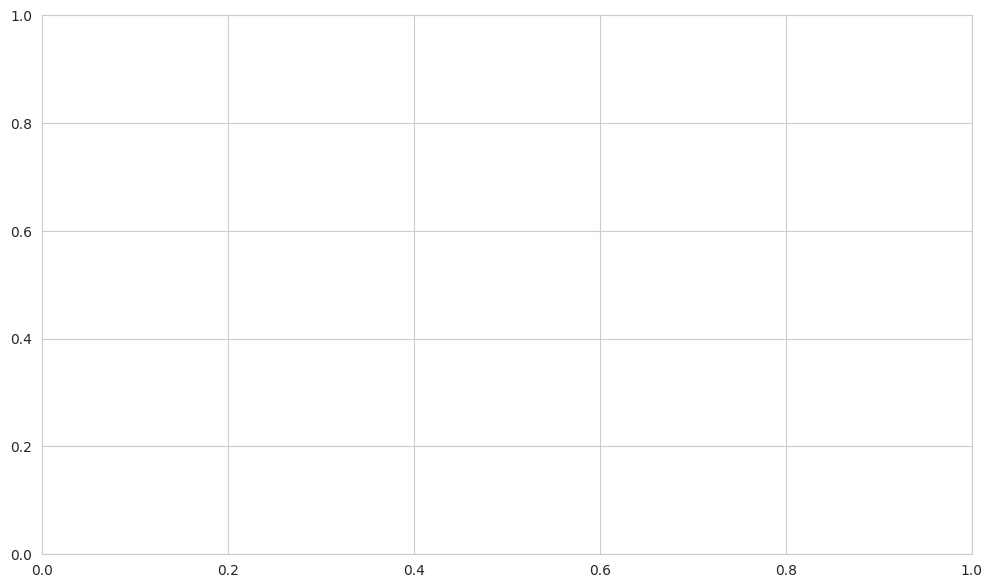

In [79]:
plot_band_score_distribution(dataset)

## Load GPT-J with Quantization for Memory Efficiency

In [53]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_id = "EleutherAI/gpt-j-6B"

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU detected! Using 4-bit quantization...")
    # Define quantization configuration
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )
    
    # Load with quantization for GPU
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=quantization_config,
        torch_dtype=torch.float16,
        device_map="auto"
    )
else:
    print("No GPU detected! For development, using a smaller model instead...")
    # For CPU development, consider using a much smaller model
    # GPT-J is too large for most CPU environments
    cpu_model_id = "distilgpt2"  # Only 82M parameters vs 6B
    model = AutoModelForCausalLM.from_pretrained(
        cpu_model_id,
        low_cpu_mem_usage=True
    )
    print(f"⚠️ NOTE: Using {cpu_model_id} instead of {model_id} for CPU development!")
    print("⚠️ Remember to switch to GPU when ready for actual fine-tuning")

# Get the tokenizer for whatever model we loaded
tokenizer = AutoTokenizer.from_pretrained(model_id if torch.cuda.is_available() else cpu_model_id)
tokenizer.pad_token = tokenizer.eos_token  # Set padding token


No GPU detected! For development, using a smaller model instead...
⚠️ NOTE: Using distilgpt2 instead of EleutherAI/gpt-j-6B for CPU development!
⚠️ Remember to switch to GPU when ready for actual fine-tuning


## Configure LoRA for Parameter-Efficient Fine-Tuning

In [54]:
# Inspect model architecture to find correct layer names
def find_target_modules(model):
    target_modules = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear) and module.weight.requires_grad:
            print(f"Found Linear layer: {name}, Shape: {module.weight.shape}")
            target_modules.append(name.split('.')[-1])  # Get just the final part of the name
    
    # Return unique module types
    return list(set(target_modules))

# Run this to see available modules
potential_targets = find_target_modules(model)
print(f"Potential target modules: {potential_targets}")

Found Linear layer: lm_head, Shape: torch.Size([50257, 768])
Potential target modules: ['lm_head']


In [114]:
# For DistilGPT2/GPT-2 style models:
peft_config = LoraConfig(
    r=8,                     # Rank dimension
    lora_alpha=32,           # Alpha parameter for LoRA scaling
    lora_dropout=0.1,        # Dropout probability for LoRA layers
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["c_attn", "c_proj"],  # Standard GPT-2 attention layers
)

# Print configuration
print(f"Using target modules for GPT-2 style architecture: ['c_attn', 'c_proj']")

# Apply LoRA to model
model = get_peft_model(model, peft_config)

# Print trainable parameters to verify setup
model.print_trainable_parameters()

print(f"Current model: `{model.config.model_type}` from `{model.config._name_or_path}`")

# You can also check more detailed information
print("\nModel details:")
print(f"Architecture: {model.__class__.__name__}")
if hasattr(model, 'config'):
    print(f"Hidden size: {model.config.hidden_size}")
    print(f"Vocabulary size: {model.config.vocab_size}")
    print(f"Number of parameters: {(sum(p.numel() for p in model.parameters())/1000000):.2f}M")

Using target modules for GPT-2 style architecture: ['c_attn', 'c_proj']
trainable params: 405,504 || all params: 82,318,080 || trainable%: 0.4926
Current model: `gpt2` from `distilgpt2`

Model details:
Architecture: PeftModelForCausalLM
Hidden size: 768
Vocabulary size: 50257
Number of parameters: 82.32M


## Define Training Arguments

In [57]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=1,   # Keep small due to memory constraints
    gradient_accumulation_steps=4,   # Accumulate gradients to simulate larger batch
    save_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True if torch.cuda.is_available() else False, # Use mixed precision
    report_to="none",                # Disable wandb reporting
    optim="adamw_torch",
    max_grad_norm=0.3,               # Gradient clipping
    warmup_ratio=0.03,               # Warmup for learning rate
)

In [11]:
# class IELTSDataCollator:
#     def __init__(self, tokenizer):
#         self.tokenizer = tokenizer
        
#     def __call__(self, entries):
#         # Extract input and output
#         inputs = [entry["input"] for entry in entries]
#         outputs = [entry["output"] for entry in entries]
        
#         # Format the text (input followed by output)
#         texts = [f"<|user|>\n{inp}\n<|assistant|>\n{out}</s>" for inp, out in zip(inputs, outputs)]
        
#         # Tokenize
#         batch = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
        
#         # For causal language modeling, use the input_ids as labels too
#         batch["labels"] = batch["input_ids"].clone()
        
#         return batch

# # Create the custom data collator
# data_collator = IELTSDataCollator(tokenizer)


## Set Up Trainer and Start Fine-Tuning

In [106]:
model.config.model_type

'gpt2'

In [100]:
model.base_model.config._name_or_path

'distilgpt2'

In [95]:
model.__dict__

{'training': True,
 '_parameters': {},
 '_buffers': {},
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': {'base_model': LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-5): 6 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): l

In [111]:
def preprocess_function(entries):
    # Format the text
    texts = [
        f"<|user|>\n{entries['input'][i]}\n<|assistant|>\n{entries['output'][i]}</s>"
        for i in range(len(entries['input']))
    ]
    
    # Tokenize
    tokenized = tokenizer(texts, padding="max_length", truncation=True, max_length=512)
    
    # For language modeling
    tokenized["labels"] = tokenized["input_ids"].copy()
    
    return tokenized

# Process the dataset
processed_dataset = train_dataset.map(
    preprocess_function, 
    batched=True,
    remove_columns=train_dataset.column_names  # Remove the original columns
)

# Define the Trainer with processed dataset
trainer = Trainer(
    model=model,
    args=training_args,  # No need for remove_unused_columns=False here
    train_dataset=processed_dataset,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False),
)

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# Start training
trainer.train()

In [13]:
# # Data collator
# data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# # Define custom data formatting function
# def formatting_func(entries):
#     texts = []
#     for i in range(len(entries["input"])):
#         text = f"<|user|>\n{entries['input'][i]}\n<|assistant|>\n{entries['output'][i]}</s>"
#         texts.append(text)
#     return texts

# # Define the Trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
# )

# # Start training
# trainer.train()

## Save the Fine-Tuned Model

In [59]:
# Save the model (just the LoRA weights, not the full model)
model.save_pretrained("./pretrained_gptj")
tokenizer.save_pretrained("./pretrained_gptj")

# Download the model to the local machine
from IPython.display import FileLinks
FileLinks(r'./pretrained_gptj')

./pretrained_gptj/
  vocab.json
  merges.txt
  adapter_model.safetensors
  tokenizer_config.json
  adapter_config.json
  tokenizer.json
  special_tokens_map.json
  README.md

### Zip into a file
For downloading in case running on online platform like Kaggle

In [60]:
# Create a zip file of the model directory
!zip -r pretrained_gptj.zip ./pretrained_gptj

# Create a download link for the zip file
from IPython.display import FileLink
FileLink("pretrained_gptj.zip")

updating: pretrained_gptj/ (stored 0%)
updating: pretrained_gptj/vocab.json (deflated 59%)
updating: pretrained_gptj/merges.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 53%)
updating: pretrained_gptj/adapter_model.safetensors (deflated 8%)
updating: pretrained_gptj/tokenizer_config.json (deflated 54%)
updating: pretrained_gptj/adapter_config.json (deflated 55%)
updating: pretrained_gptj/tokenizer.json (deflated 82%)
updating: pretrained_gptj/special_tokens_map.json (deflated 60%)
updating: pretrained_gptj/README.md (deflated 66%)


/kaggle/working/pretrained_gptj.zip

## Load Model

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel, PeftConfig

# Load the base model first
base_model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B")

# Load your fine-tuned LoRA weights
peft_model_id = "./downloaded_location/pretrained_gptj"
model = PeftModel.from_pretrained(base_model, peft_model_id)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(peft_model_id)

# Your model is ready to use!


## Test the Fine-Tuned Model

In [ ]:
# Test the model on an entry
s = "Rate this IELTS essay: In some countries, young people are encouraged to work or travel for a year between finishing high school and starting university studies. Discuss the advantages and disadvantages for young people who decide to do this."

inputs = tokenizer(test_input, return_tensors="pt").to("cuda")
output = model.generate(
    inputs.input_ids,
    max_new_tokens=512,
    temperature=0.7,
    top_p=0.9,
    repetition_penalty=1.2
)

print(tokenizer.decode(output[0], skip_special_tokens=True))

In [68]:
test_input = test_dataset['input'][0]

inputs = tokenizer(test_input, return_tensors="pt").to("cuda")
output = model.generate(
    inputs.input_ids,
    max_new_tokens=512,
    temperature=0.7,
    top_p=0.9,
    repetition_penalty=1.2
)

print(tokenizer.decode(output[0], skip_special_tokens=True))


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx